In [1]:
import numpy as np
from typing import Callable, Tuple
import matplotlib.pyplot as plt

In [2]:
def get_params(c2: float) -> Tuple:
    if c2 > 1 or c2 < 0:
        raise ValueError('с2 не пренадлежит [0, 1]')
    c1 = 1 - c2
    a = 0.5 / c2
    b = 0.5 / c2
    return (a, b, c1, c2)


def f(x: float, y: np.array) -> np.array:
    A = -3
    B = 2.5
    C = 1
    f1 = 2 * x * (y[1] ** (1 / B)) * y[3]
    f2 = 2 * B * x * np.exp((B / C) * (y[2] - A)) * y[3]
    f3 = 2 * C * x * y[3]
    f4 = -2 * x * np.log(y[0])
    return np.array([f1, f2, f3, f4])

    
def phi(f: Callable, x: float, y: np.array, h: float, params: Tuple) -> np.array:
    a, b, c1, c2 = params
    fxy = f(x, y)
    return np.array(c1 * fxy + c2 * f(x + a * h, y + b * h * fxy))


def make_2deg_rk_step(f: Callable, x_current: float, y_current: np.array, h_current: float, params: Tuple) -> np.array:
    if len(y_current) != 4:
        raise ValueError('Вектор не из R4')
    return y_current + h_current * phi(f, x_current, y_current, h_current, params)


def real_y(x: float) -> np.array:
    A = -3
    B = 2.5
    C = 1
    y1 = np.exp(np.sin(x ** 2))
    y2 = np.exp(B * np.sin(x ** 2))
    y3 = C * np.sin(x ** 2) + A
    y4 = np.cos(x ** 2)
    return np.array([y1, y2, y3, y4])

[1.56250000e-02 7.81250000e-03 3.90625000e-03 1.95312500e-03
 9.76562500e-04 4.88281250e-04 2.44140625e-04 1.22070312e-04
 6.10351562e-05]
[0.8850934175530027, 0.19950174740223597, 0.0443429185620203, 0.010248505778458991, 0.0024513647224199526, 0.0005987042213551889, 0.0001478933379754085, 3.674959660090785e-05, 9.159365293789837e-06]


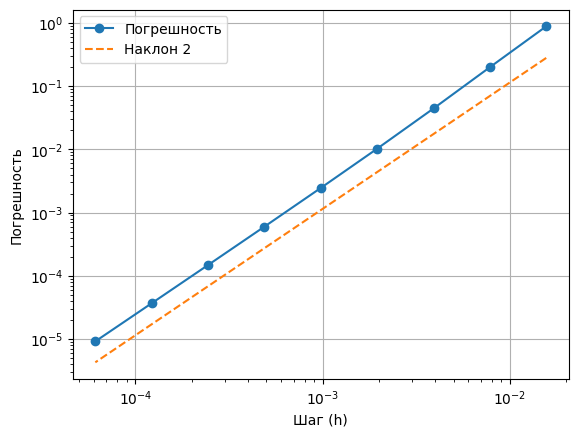

In [21]:
A = -3
B = 2.5
C = 1

x0 = 0
x1 = 5

y0 = np.array([1, 1, A, 1])

h = np.array([1 / 2 ** k for k in range(6, 15)])

error = []
for current_h in h:
    x = x0
    y = y0
    while x < x1:
        y = make_2deg_rk_step(f, x, y, current_h, get_params(0.4))
        x += current_h
    error.append(np.linalg.norm(real_y(x1) - y))

print(h)
print(error)

plt.figure()
plt.loglog(h, error, marker='o', label='Погрешность')
plt.loglog(h, (error[0] / h[0]**2 / np.sqrt(10) )* h** 2, '--', label='Наклон 2')

plt.xlabel('Шаг (h)')
plt.ylabel('Погрешность')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def estimate_error(yn, y2n):
    return np.abs(np.linalg.norm(y2n - yn) / 3)

def normalize_step_size(step_size, a, b):
    return (b - a) / np.round((b - a) / step_size, 0)

def update_step(step, tol, error):
    return step * 0.5 * (tol / error) ** 0.5


A = -3
B = 2.5
C = 1

x0 = 0
x1 = 5

y0 = np.array([1, 1, A, 1])

h = 0.5 ** 10
h = normalize_step_size(h, A, B)
tol = 10 ** -5


max_iter = 3
for _ in range(max_iter):
    x = x0
    y = y0
    while x < x1:
        y = make_2deg_rk_step(f, x, y, h, get_params(0.4))
        x += h
        
    x = x0
    y2n = y0
    h = h / 2
    while x < x1:
        y2n = make_2deg_rk_step(f, x, y2n, h, get_params(0.4))
        x += h
        
    error = estimate_error(y, y2n)
    print(h, error)

    if error < tol:
        break
    else:
        h = update_step(h, tol, error)
        h = normalize_step_size(h, A, B)


0.00048828125 0.000617553530295994
1.55336515378315e-05 5.925740234119947e-07


In [34]:
def estimate_local_error(yn, y2n):
    return np.linalg.norm(y2n - yn) / 0.75, np.linalg.norm(y2n - yn) / 3

def update_step(step, tol, error):
    return step * 0.5 * (tol / error) ** (1 / 3)

def normalize_step_size(step_size, a, b):
    return (b - a) / np.round((b - a) / step_size, 0)

In [35]:
A = -3
B = 2.5
C = 1

x0 = 0
x1 = 5

y0 = np.array([1, 1, A, 1])

tol = 10 ** -5

In [48]:
step_history = []
error_history = []
x_history = []
y_history =[]
params = get_params(0.4)

x = x0
y = y0

h = 0.5 ** 10

while x < x1:    
    if x + h > x1:
        h = x1 - x
    local_x_n_steps = x
    local_x_2n_steps = x
    local_y_n_steps = y
    local_y_2n_steps = y
    
    local_y_n_steps = make_2deg_rk_step(f, local_x_n_steps, y, h, params)
    local_x_n_steps += h
    
    for _ in range(2):
        local_y_2n_steps = make_2deg_rk_step(f, local_x_2n_steps, local_y_2n_steps, h / 2, params)
        local_x_2n_steps += h / 2
        
    error_n_steps, error_2n_steps = estimate_local_error(local_y_n_steps, local_y_2n_steps)
    
    if error_n_steps < tol:
        x = local_x_n_steps
        y = local_y_2n_steps + (local_y_2n_steps - local_y_n_steps) / 3
        h = update_step(h, tol, error_n_steps)
    elif error_2n_steps < tol:
        x = local_x_2n_steps
        y = local_y_2n_steps + (local_y_2n_steps - local_y_n_steps) / 3
        h = update_step(h / 2, tol, error_2n_steps)
    else:
        h = update_step(h / 2, tol, error_2n_steps)
    
    y_history.append(y)
    x_history.append(x)
    step_history.append(h)
    error_history.append((error_n_steps, error_2n_steps))

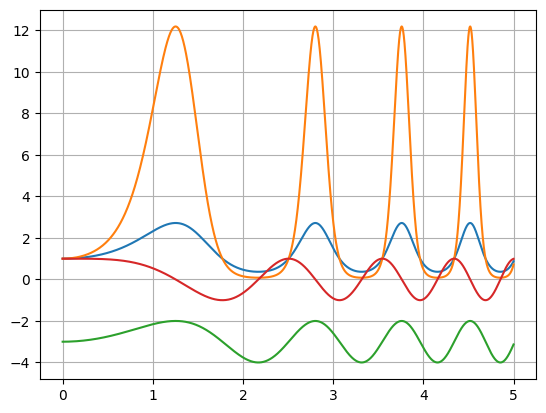

In [49]:
plt.figure()
plt.plot(x_history, y_history)

plt.grid(True)
plt.show()

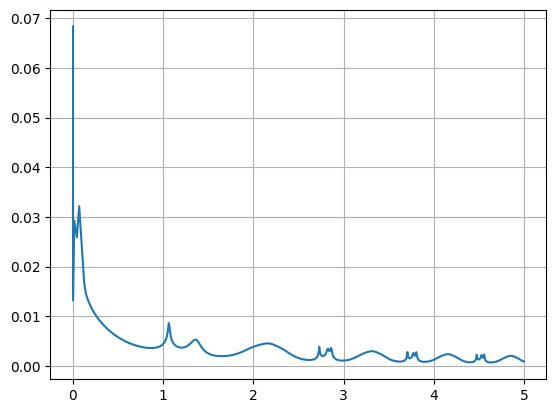

In [50]:
plt.figure()
plt.plot(x_history, step_history)

plt.grid(True)
plt.show()

In [58]:
tol = [
    10 ** -5,
    10 ** -6,
    10 ** -7,
    10 ** -8,
]

real_error_history = []

for current_tol in tol:
    # step_history = []
    # error_history = []
    # x_history = []
    # y_history =[]
    params = get_params(0.4)
    
    x = x0
    y = y0
    
    h = 0.5 ** 10
    
    while x < x1:    
        if x + h > x1:
            h = x1 - x
        local_x_n_steps = x
        local_x_2n_steps = x
        local_y_n_steps = y
        local_y_2n_steps = y
        
        local_y_n_steps = make_2deg_rk_step(f, local_x_n_steps, y, h, params)
        local_x_n_steps += h
        
        for _ in range(2):
            local_y_2n_steps = make_2deg_rk_step(f, local_x_2n_steps, local_y_2n_steps, h / 2, params)
            local_x_2n_steps += h / 2
            
        error_n_steps, error_2n_steps = estimate_local_error(local_y_n_steps, local_y_2n_steps)
        
        if error_n_steps < current_tol:
            x = local_x_n_steps
            y = local_y_2n_steps + (local_y_2n_steps - local_y_n_steps) / 3
            h = update_step(h, current_tol, error_n_steps)
        elif error_2n_steps < current_tol:
            x = local_x_2n_steps
            y = local_y_2n_steps + (local_y_2n_steps - local_y_n_steps) / 3
            h = update_step(h / 2, current_tol, error_2n_steps)
        else:
            h = update_step(h / 2, current_tol, error_2n_steps)
        
        # y_history.append(y)
        # x_history.append(x)
        # step_history.append(h)
        # error_history.append((error_n_steps, error_2n_steps))
    
    real_error_history.append(np.linalg.norm(real_y(x1) - y))

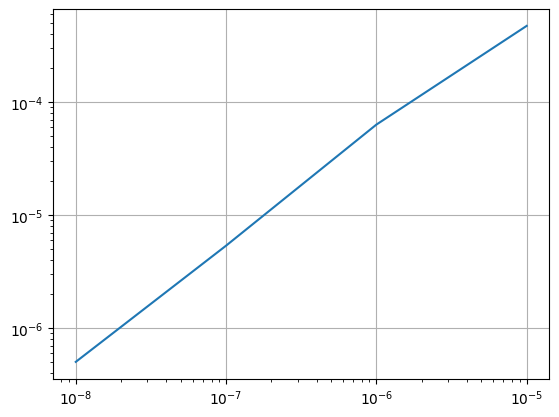

In [60]:
plt.figure()
plt.loglog(tol, real_error_history)

plt.grid(True)
plt.show()